# Airway segmentation in chest CT scans
<img src="figures/airway.jpg" width="120" height="120" align="right">
In this assignment, you will develop a CAD system for automatic segmentation of airways in chest CT scans. The images used in this assignment are extracted from the EXACT09 challenge, which was organized in 2009. The website of the EXACT09 challenge can be found at this link: http://image.diku.dk/exact/.
You will be developing your CAD system in this notebook, but we propose using MeVisLab as a tool to visualize the results of your segmentation.
In order to install MeVisLab, please follow the instructions detailed in the Google groups at this link: https://groups.google.com/forum/#!topic/ismi18/_M6pfZ91y00 (see section on "Installing MeVisLab").

## Teaching assistants

- Ajay Patel: ajay.patel@radboudumc.nl
- Midas Meijs: midas.meijs@radboudumc.nl

## Students

Please fill in this cell with your name and e-mail address. This information will be used to grade your assignment.

* Name student #1, email address: ...
* Name student #2, email address: ...

## Instructions

* Groups: You should work in pairs or alone
* Deadline for this assignment: 
 * Tuesday (February 27th) until midnight
 * 5 points (maximum grade = 100 points) penalization per day after deadline
* Submit your **fully executed** notebook to the grand-challenge.org platform
* The grades will be available before March 2nd (tentative)

This notebooks contains cells with snippets of code that we provide in order to load and visualize data, but also some convenience functions that could be useful to develop your assignment.


We also provide templates for functions that have to be implemented, with a given list of input variables and some output variables. **Feel free to modify the input and output variables to adapt them to your favourite implementation.** However, this should at least provide the outputs required to develop the rest of the notebook.


Your submission should contain the **fully executed** notebook with **your code** implemented, as well as **your answers** to questions, which will be used to grade your assignment.

## Tasks for this assignment

This assignement consist of two main tasks:

1. Develop an algorithm for **automatic airway segmentation** based on connected component.
2. Improve the performance of your algorithm by combining your solution with other known techniques.

## Task 1 (max 80 points):

### Develop an algorithm for automatic airway segmentation 

* Use (double) thresholding techniques, find the optimal value of threshold per scan
* Use connected components, find the best neighborhood strategy empirically
* Use the trachea seed point to detect the connected component that belong to airways
* Implement some explosion control technique, you can use the data from training set for that

### Submission to the grand-challenge.org
The output of this assignment must be the airway segmentation for the 10 test cases from the EXACT09 challenge, provided together with this notebook.
In order to generate and submit the results to the grand-challenge website:
* Run your airway segmentation algorithm on the 10 test images
* Save the segmentation output (3D matrix) as an ITK file to a local folder. **Segmented airway voxels should have a value different from zero**. 
* Create a zip-file of your final results.
* Submit the results to the grand challenge website.

## Task 2 (max 20 points):

### Improve airway segmentation

Use your knowledge on *filtering*, *texture descriptors* and *morphology* to improve the result of your airway segmentation method. Your improvement can be based on some post-processing of the result obtained with connected components, or a new solution. Be creative!

# Introduction

In this assignment, we are going to develop a system for automatic segmentation of airways in chest CT scans. The input data is a 3D volume of the human thorax. An example of *coronal* slice of this 3D volume is shown in Figure 1a. The output of this assignment is also a 3D volume containing binary values for each voxel, indicating whether it belongs to an airway or not. The output airway segmentation should be a single **connected component**. An example of this output is shown as a coronal 2D overlay in Figure 1b and as a 3D volume in Figure 1c.

<img src="./figures/exampleCT_and_airwaySegmentation_small.png" alt="example coronal slice of an chest CT and an example airway segmentation" style="width:1000px;height:300px;">
<I>Figure 1. An example of coronal slice of a 3D chest CT scan (a) and an example of output of an airway segmentation algorithm (b and c). The example airway segmentation is shown as a red overlay in (b) and as a 3D rendering in (c). The blue arrows in (b) show some examples of an airway wall.</I>
<br>
<br>
The main goal of airway segmentation is to differentiate the airway lumen from the surrounding lung tissue (also called <I>lung parenchyma</I>). Both appear as dark voxels on CT but are separated by the airway wall which appear as a brighter tube surrounding the airway lumen. The blue arrows in Figure 1b give some examples of an airway wall. For the larger airways, the thick airway walls provide a clear separation between the airway lumen and the surrounding lung parenchyma. However, this separation becomes less pronounced for smaller airways because of limitations in resolution and partial volume effects, which often results in a segmentation that leaks into the lung parenchyma as is shown in Figure 2b and 2c. 

<img src="./figures/exampleCT_and_airwaySegmentation_small_leaks.png" alt="example coronal slice of an chest CT and an example airway segmentation" style="width:1000px;height:300px;">
<I>Figure 2. An example of the same coronal slice as shown in Figure 1, but with an airway segmentation that leaked into the lung parenchyma (b and c). The example leaky airway segmentation is shown as a red overlay in (b) and as a 3D rendering in (c).</I>
<br>
<br>
A common issue when segmenting airways is **how to define a good trade-off between increasing the airway tree length and reducing the number of leaks**. In most methods, this trade-off is determined by optimising the parameters that influence the tree length and the number of leaks.



## Clinical background

Airway segmentation in CT plays an important role in the analysis of pulmonary diseases. A robust method to automatically segment an airway tree in CT is especially relevant for quantifying airway changes such as thickening of the airway wall and changes in lumen diameter. Quantifying these airway changes may be key for improving the diagnosis and treatment planning for pulmonary diseases involving airway pathology such as chronic obstructive pulmonary disease (COPD), cystic fibrosis, or bronchiectasis. In addition, segmented airways can aid in segmenting other pulmonary structures such as lobes, segments, and pulmonary arteries and veins.

## Initialization
First, we import the basic libraries necessary to develop this assignment. Feel free to include more libraries if needed.

In [3]:
# import libraries needed for this assignment
import requests
import zipfile
from tqdm import tnrange, tqdm_notebook
import SimpleITK as sitk
import os
import dicom
import ntpath
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology
%matplotlib inline
from IPython import display
import shutil
import time

## Data

For the development and evaluation of your airway segmentation method, we are going to use data from an internationally recognised challenge for airway segmentation (EXACT'09, http://image.diku.dk/exact/). The goal of EXACT'09 is to compare algorithms that extract the airway tree from chest CT scans using a common data set of 20 chest CT scans. From EXACT09, we selected 10 cases for training and 10 cases for test.

The data for this assignment can be downloaded by executing the next cell. This will download and uncompress data contained in the file ```EXACT09.zip``` to a folder ```/your_notebook_directory/assignment_3```. After the file is unzipped, it is removed.

Run the next cell and wait until the progress bar becomes green. **This can take up to 30 minutes (file size ~2GB).**

The original evaluation of the EXACT09 challenge focusses on the following measurements:

- airway tree length (in mm)
- percentage of detected airway tree length (as compared to the reference standard)
- volume of leaked voxels (in mm<sup>3</sup>)
- false positive rate (percentage of leaked voxels as compared to correctly segmented voxels)

However, in order to simplify the evaluation procedure, in this assignment we are only going to consider the **Dice** score.

In order to develop your method, a set of 10 chest CT scans with reference airway segmentations are made available (training/tuning set). These reference airway segmentations will give you a good idea on what you may expect from your segmentation algorithm, and may be used to train/tune your algorithm.

In [2]:
link = 'https://surfdrive.surf.nl/files/index.php/s/14Kzw0J88WWSlnN/download'
file_name = "EXACT09.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./EXACT09.zip')

HBox(children=(IntProgress(value=1, bar_style='info', description='Downloading data', max=1), HTML(value='')))

KeyboardInterrupt: 

Convenience function to read list of files in a directory (also used in previous assignments)

In [1]:
def get_file_list(path,ext='',queue=''):
    if ext != '': return [os.path.join(path,f) for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')],  [f for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')]    
    else: return [os.path.join(path,f) for f in os.listdir(path)]

Define paths to the data used in this assignment and extract list of filenames. Adjust the 'data_folder' path to match your local settings.

In [4]:
# path to the folder with the data you downloaded from SURFDrive
data_folder = './assignment_3'

# training images
tra_img_dir = os.path.join(data_folder, 'training' , 'images')
# training annotations
tra_ann_dir = os.path.join(data_folder, 'training', 'annotations')
# test images
tes_img_dir = os.path.join(data_folder, 'test', 'images')

tra_img_fls = get_file_list(tra_img_dir, 'dcm')[0] # dicom files
tra_ann_fls = get_file_list(tra_ann_dir, 'mhd')[0] # ITK files
tes_img_fls = get_file_list(tes_img_dir, 'dcm')[0] # dicom files

print('== Training images ==')
[print(tra_img_fl) for tra_img_fl in tra_img_fls]
print('\n== Training annotations ==')
[print(tra_ann_fl) for tra_ann_fl in tra_ann_fls]
print('\n== Test images ==')
[print(tes_img_fl) for tes_img_fl in tes_img_fls]

== Training images ==
./assignment_3/training/images/scan17.dcm
./assignment_3/training/images/scan07.dcm
./assignment_3/training/images/scan01.dcm
./assignment_3/training/images/scan05.dcm
./assignment_3/training/images/scan12.dcm
./assignment_3/training/images/scan18.dcm
./assignment_3/training/images/scan04.dcm
./assignment_3/training/images/scan10.dcm
./assignment_3/training/images/scan08.dcm
./assignment_3/training/images/scan15.dcm

== Training annotations ==
./assignment_3/training/annotations/scan12.mhd
./assignment_3/training/annotations/scan18.mhd
./assignment_3/training/annotations/scan05.mhd
./assignment_3/training/annotations/scan17.mhd
./assignment_3/training/annotations/scan10.mhd
./assignment_3/training/annotations/scan01.mhd
./assignment_3/training/annotations/scan04.mhd
./assignment_3/training/annotations/scan08.mhd
./assignment_3/training/annotations/scan07.mhd
./assignment_3/training/annotations/scan15.mhd

== Test images ==
./assignment_3/test/images/1.0.000.000000

[None, None, None, None, None, None, None, None, None, None]

Define the path for your output results. By default, it is a ```result``` folder in the directory of this notebook. Feel free to change it if you like. In this folder, you will have to look for your results when you want to visualize them.

In [5]:
# set output folder (required to submit result to the grand-challenge)
result_output_folder = os.path.join('./results')
if not(os.path.exists(result_output_folder)):
    os.makedirs(result_output_folder)

Convenience function to load a file in ITK format and return both an ITK and a numpy version of it. Having both the ITK file format and the numpy format is handy, because ITK files contain information about the scan, like spacing (voxel size) etc. However, using numpy format is convenient when operations on matrixes have to be applied.

In [6]:
def load_itk_file(file_name):
    ''' load itk image file. '''
    img_itk = sitk.ReadImage(file_name)
    img_np = sitk.GetArrayFromImage(img_itk)
    return img_itk, img_np

Convenience function to save files in ITK format. Although other formats are available in ITK, in this assignment we want to use ```mhd``` files, which is the format supported by the grand-challenge evaluation script. Note that the image parameters *spacing*, *origin* and *direction* are used in the function.

In [7]:
def save_itk_file(img, filename, img_params, use_compression=True):
    ''' Save input image 'img' in ITK format mhd. 
        It requires a filename to save the input image, and
        a set of ITK parameters, like spacing, origin and direction
        to properly store the image. If the input image is not
        in numpy format, img_params are ignored.
    '''
    if not filename.endswith('mhd'):
        print ('filename should have extension .mhd!')
        return False
    # check if the input variable is a numpy array
    if type(img).__module__ == np.__name__:
        itk_img = sitk.GetImageFromArray(img) # convert it
        itk_img.SetSpacing(img_params['spacing'])
        itk_img.SetOrigin(img_params['origin'])
        itk_img.SetDirection(img_params['direction'])
    else:
        itk_img = img
    w = sitk.ImageFileWriter()
    w.SetUseCompression(use_compression)
    w.SetFileName(filename)
    w.Execute(itk_img)
    return True

## Visualization with MeVisLab 

A nice way to visualize images and annotations is by using MeVisLab. You can download MeVisLab for your operating system (it supports Windows, Linux and Mac OS) from this link: http://www.mevislab.de/download/.
MeVisLab comes with the ITK library installed, which you can use to load both the CT scan, the reference standard and your segmentation result, and inspect it by scrolling the scan in 2D or in 3D. These are two examples of how you can visualize your segmentation result in MeVisLab:

<img src="./figures/mevislab_overlay_example.png" alt="MeVisLab overlay">

To scroll up and down in the 2D visualization, just use the weel of your mouse, or press it to do a quick scrolling.
To zoom in and out in the 3D view, use the combination of keys "CTRL + central mouse button".
You will find a file called ```network_visualization.mlab``` in the folder of this assignment, open it to load the network in the example and use it to visualize your results.

Try to open a few training cases and overlay the provided airway annotations. This will be useful to get familiar with the kind of images you will have to process and with the appearance of airways in CT scans.

#### MeVisLab tips & tricks
* In MeVisLab, you can change the window level (look-up-table) used to visualize image intensities by clicking the right button of your mouse and moving the cursor around. You will see that the gray levels change. This may be useful to get an optimal visualization of the lungs and to visualize airways.
* In the network provided, we included a module called ```OrthoSwapFlip```. Double click on the module and check the options available. One option is called *View Direction*. Change the value in the menu and check how the view changes in the window.
* You can switch from voxel coordinates to world coordinates in the View2D module by doing: 
   
   *click on the right button > Show Window > Settings > Appearance [TAB] > Current Pos. in > Voxel/World.*


* Now we are using MeVisLab to visualize the provided manual annotations overlayed on training images. You can imagine that later the same network can be used to inspect test cases, and to overlay the segmentation results provided by your algorithm. 

### About CT scans
Typically, CT scans are acquired from the bottom part of the body to the top part, and during the acquisition, slices are stored.
For this reason, the slice with index zero in the CT scan actually corresponds to the last slice, if you see the scan from top to bottom. This also means that the lung that you see on the left is actually the right lung, and the other way around. It is important to keep these things in mind while developing algorihtms for medical image analysis!

## Task 1. Airway segmentation with explosion control

### Extract airway volume statistics

One of the problems of airway segmentation is that airways can easily leak into the lung parenchyma, since the intensity of the parenchyma is also low, and airway walls are sometimes thin. For this reason, during the segmentation procedure, knowing what is the **volume of airway** that we can expect can help prevent explosion of airway segmentation into the parehcnyma. In order to do that, we can get statistics on airway volume from the training set provided with this assignment.

Implement a function that computes the mean volume, in **mm<sup>3</sup>**, of an airway tree using data from the training set. Use all the scans in the training set to compute the mean volume.

**NOTE:** You can get the *spacing* information from ITK images using the function ```GetSpacing()``` of the image object itself.

In [8]:
# function to compute the mean volume
def get_mean_volume_mm3(file_lst):
    ''' 
        Compute the mean volume (in mm^3) of airway tree from a given set.
        The input is a list of ITK files of annotated airway trees.
    '''
    volume_mm3 = []
    for filename in file_lst:
        print (filename)
        annotation_itk, annotation_np = load_itk_file(filename)
        volume_pixel = np.prod(annotation_itk.GetSpacing())
        volume_img = np.sum((annotation_np[annotation_np==1])) * volume_pixel
        volume_mm3.append(volume_img)
        
#         print("Image Shape", annotation_np.shape)
#         print("Get total volume", np.prod(annotation_np.shape * np.array(annotation_itk.GetSpacing())))
#         print("Volume Trachea", volume_img)
    print("Max ", max(volume_mm3))
    print("Min ", min(volume_mm3))
    return np.mean(volume_mm3)

#### Question
We asked to compute the **mean** volume from the training set. Do you think that other statistics would be useful to implement an *explosion control* algorithm? Why?

*Your answer here.* We can compute max, min, std. And threshold our algorithm to mean + 3 std or something so that it is more flexible than having a hard threshold.

**NOTE.** If you think that other statistics are needed, feel free to expand the ```get_mean_volume_mm3()``` function to include more statistics, or to implement more functions.

Now we can compute (at least) the mean volume using the function we have defined.

In [9]:
# extract list of airway annotation files
tra_ann_list = get_file_list(tra_ann_dir, 'mhd')[0]

# compute the mean airway volume using the function you have implemented
mean_volume_mm3 = get_mean_volume_mm3(tra_ann_list)
print('Mean volume = {} mm^3'.format(mean_volume_mm3))

./assignment_3/training/annotations/scan12.mhd
./assignment_3/training/annotations/scan18.mhd
./assignment_3/training/annotations/scan05.mhd
./assignment_3/training/annotations/scan17.mhd
./assignment_3/training/annotations/scan10.mhd
./assignment_3/training/annotations/scan01.mhd
./assignment_3/training/annotations/scan04.mhd
./assignment_3/training/annotations/scan08.mhd
./assignment_3/training/annotations/scan07.mhd
./assignment_3/training/annotations/scan15.mhd
Max  43400.87890625
Min  14901.290151894202
Mean volume = 23066.43634815252 mm^3


Now that we have computed the mean volume, we can use it to implement some kind of explosion control in our airway segmentation algorithm. We have to segment airways in all test cases. Therefore, for each case, the tasks are the following:

* load the scan
* pick a seed point in the trachea
* do connected components segmentation, based on threshold(s)
* use the seed point to select the connected component related to airways
* in your algorithm, use the learned mean volume to pick the optimal threshold that prevents (limits) leakage

#### About trachea seed point
In order to develop your algorihtm, you will need the coordinates of a seed point placed in the trachea.
This is related to what we developed in the first assignment!
However, due to noise in CT scans, good seed points are typically defined close to the **carina point**. 
The seed point produced by the algorithm that you developed in the first assignment may give a different location, since it was not optimized for that (we simply did not ask for that).

To solve this problem, we manually picked seed points for the test cases of this assignment, which you can find in the dictionary defined in the next cell.

In [10]:
# seed points dictionary (z, y, x)
seed_points = {}
seed_points['1.0.000.000000.0.00.0.0000000000.0000.0000000000.000'] = (327, 249, 245)
seed_points['1.2.276.0.28.3.0.14.4.0.20090213134050413'] = (258, 263, 251)
seed_points['1.2.276.0.28.3.0.14.4.0.20090213134114792'] = (251, 260, 248)
seed_points['1.2.392.200036.9116.2.2.2.1762676169.1080882991.2256'] = (303, 286, 249)
seed_points['1.2.840.113704.1.111.2004.1131987870.11'] = (202, 235, 251)
seed_points['1.2.840.113704.1.111.2296.1199810886.7'] = (358, 331, 247)
seed_points['1.2.840.113704.1.111.2296.1199810941.11'] = (336, 335, 248)
seed_points['1.2.840.113704.1.111.4400.1131982359.11'] = (227, 200, 252)
seed_points['1.3.12.2.1107.5.1.4.50585.4.0.7023259421321855'] = (287, 273, 258)
seed_points['2.16.840.1.113669.632.21.3825556854.538251028.390606191418956020'] = (180, 257, 238)

**NOTE.** In the training set, a region growing algorithm based on seed points was used to build the reference segmentation. This means that the volume of trachea above the seed point is not considered in the computation of the mean volume. You will have to take this into account when developing the explosion control part of your algorithm! 

#### Question
Are the seed-point coordinates given in voxel-coordinates or world-coordinates? What is the difference between world-coordinates and voxel-coordinates?

*Your answer here.* The coordinates are in voxel-coordinates.

### Auxiliary functions

In the following cells, we propose templates of code that you can use to implement functions that will be necessary to run the main airway segmentation algorithm, with explosion control. The idea is that you implement simple functions that can do specific tasks, and then these functions will be used in the last cells of the notebook to define the main function for airway segmentation, and to run the main script that segments airways in the test set. Let's get started!

Implement a function to get parameters from the image in ITK format. The parameters we need to extract are:
  * origin
  * spacing
  * direction

In [11]:
def get_scan_params(img_itk):
    # >>> YOUR CODE HERE, Replace 'None's with your code <<<
    img_params = {}
    import pdb; pdb.set_trace
    img_params['origin'] = img_itk.GetOrigin()
    img_params['spacing'] = img_itk.GetSpacing()
    img_params['direction'] = img_itk.GetDirection()
    return img_params

#### Question
What is the data format of the *spacing* object, and what is the meaning of its values?

*Your answer here.* The size of each voxel in x, y and z directions.

Implement a function that computes the volume of a voxel in mm<sup>3</sup> given the spacing vector

In [12]:
def get_voxel_volume_mm3(spacing):
    # >>> YOUR CODE HERE, Replace 'None's with your code <<<
    voxel_volume_mm3 = np.prod(spacing)
    return voxel_volume_mm3

Based on the result of the connected component algorithm, we will extract the segmentation of airways as the connected component that contains the seed point provided. Since images can be very noisy, the seed point may not belong to any connected component, but still very close to it. For this reason, given a seed point, we will have to check for labels available in its neighborhood, and pick the one of the closest component. 

The following function implements this idea by considering voxels of connected components in a cube of size (2d+1)x(2d+1)x(2d+1) centered on the seed point. By default, the size of the cube is 21 voxels, but you can tune this parameter and see if this affects your results. We still don't have the volume of connected components, but we will extract it later in the main script. For the time being, think of it as a 3D matrix in numpy, where each connected structure in 3D is assigned a different label (a different number >0).

In [13]:
def get_seed_point_label(conn_comps, seed_point, d=10):
    ''' 
        Detect the closest label in a (2d+1) x (2d+1) x (2d+1) cube 
        centered on the seed point.
    '''
    distances = []
    labels = []
    for dx in range(-d, d):
        for dy in range(-d, d):
            for dz in range(-d, d):
                label = conn_comps[seed_point[0] + dz,
                                   seed_point[1] + dy,
                                   seed_point[2] + dx]
                if label != 0:
                    labels.append(label)
                    distances.append(np.sqrt(float(dx)**2 + float(dy)**2 + float(dz)**2.))
    if len(labels) == 0:
        return 0
    else:
        return labels[np.argmin(np.array(distances))]

In [14]:
tra_img_list = get_file_list(tra_img_dir, 'dcm')[0]
print(get_scan_params(load_itk_file(tra_img_list[0])[0]))

{'spacing': (0.708984375, 0.708984375, 0.7000120000000043), 'origin': (-192.5, -59.5, -333.5), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)}


### Main airway segmentation function

Implement a function that performs airway segmentation of a given CT scan in numpy array format based on connected components. The function needs at least the following inputs:

* ```img_np```: CT scan in numpy array format
* ```seed_point```: coordinates of the seed point in 3D, oriented as (z, y, x)
* ```thresholds```: list of threshold(s) you want to apply to extract a binarized version of the image, to use as input for the connected component algorithm

In the development of this function, consider that:
* each threshold will generate a certain volume, which we will have to compare with the mean volume learned from the training set, to implement explosion control; keep track of the volumes in a list
* the z-coordinate of the seed point defines the last slice to consider in your volume, because you want to discard a part of the trachea and make your volume comparable with the one learned from the training set.

We have defined the structure of this (long) function, and already implemented some of its parts. Fill in the missing lines of code. This function will be used later in the main script to run airway segmentation on the entire test set.

In [28]:
from numba import jit

In [115]:
# current label = 1
# for each pixel if pixel is not yet labeled
    # if neigbours (that are 1s) have any label, 
        # assign the minimal label to the pixel
    # in not
        # label with current label and assign current label for all the neigbours

def check_neighbors_new(conn_comps, point):
    labels = np.zeros((3, 3, 3))
    for dx in range(3):
        for dy in range(3):
            for dz in range(3):
                # Substracting 1 from indices because we are using range(3)
                labels[dx, dy, dz] = conn_comps[point[0] + dx - 1, point[1] + dy - 1, point[2] + dz - 1]

    try:
        return_value = min(labels[labels != 0])
    except:
        return_value = None
    
    return return_value

def assign_neighbors_new(conn_comps, binary_img, point, curr_label):
    labels = np.zeros((3, 3, 3))
    for dx in range(3):
        for dy in range(3):
            for dz in range(3):
                if binary_img[point[0] + dx - 1, point[1] + dy - 1, point[2] + dz - 1]: # if neighbour is 1
                    conn_comps[point[0] + dx - 1, point[1] + dy - 1, point[2] + dz - 1] = curr_label
    return conn_comps   

@jit
def connected_comps_new(binary_img):
    curr_label = 0
    conn_comps = np.zeros(binary_img.shape, dtype=int)
    n_rows, n_cols, n_slice = binary_img.shape
    for row in range(1, n_rows-1):
        for col in range(1, n_cols-1):
            for sl in range(1, n_slice-1):
                # If the current point is 1, then check for neighbor and if there is a neighbour
                # assign it's label to current point.
                if binary_img[row, col, sl] == 1:
                    if conn_comps[row, col, sl] == 0: # SO WE EXCLUDE PIXELS FOR THOSE WE HAVE ALREADY ASSIGNED THE LABEL
                        neighbor_label = check_neighbors_new(conn_comps, (row, col, sl))
                        if neighbor_label is None:
                            curr_label += 1
                            conn_comps[row, col, sl] = curr_label
                            # assign neighbor_label to all neighbours
                            conn_comps = assign_neighbors_new(conn_comps, binary_img, (row, col, sl), curr_label)
                        else:
                            conn_comps[row, col, sl] = neighbor_label
                            # assign neighbor_label to all neighbours
                            conn_comps = assign_neighbors_new(conn_comps, binary_img, (row, col, sl), curr_label)
    return conn_comps

In [121]:
dummy_array = np.array([
                       [[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 1, 1, 0, 0],
                        [0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                        [[0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                        [[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]]])

t1 = time.time()
c1 = connected_comps_new(dummy_array)
t2 = time.time()
print(t2 - t1)

print('-' * 40)

t1 = time.time()
c2 = connected_comps(dummy_array)
t2 = time.time()
print(t2 - t1)


0.0004165172576904297
----------------------------------------
0.0004036426544189453


I think my version works a bit (0.0001s) faster and it assigns correct labels right away, so that we don't need to recalculate our connectivity table

In [114]:
def check_neighbors(conn_comps, point):
    labels = np.zeros((3, 3, 3))
    for dx in range(3):
        for dy in range(3):
            for dz in range(3):
                # Substracting 1 from indices because we are using range(3)
                labels[dx, dy, dz] = conn_comps[point[0] + dx - 1, point[1] + dy - 1, point[2] + dz - 1]

    try:
        return_value = min(labels[labels != 0])
    except:
        return_value = None
    
    return return_value
        
                    
@jit
def connected_comps(binary_img):
    curr_label = 0
    conn_comps = np.zeros(binary_img.shape, dtype=int)
    n_rows, n_cols, n_slice = binary_img.shape
    for row in range(1, n_rows-1):
        for col in range(1, n_cols-1):
            for sl in range(1, n_slice-1):
                # If the current point is 1, then check for neighbor and if there is a neighbour
                # assign it's label to current point.
                if binary_img[row, col, sl] == 1:
                    neighbor_label = check_neighbors(conn_comps, (row, col, sl))
                    if neighbor_label is None:
                        curr_label += 1
                        conn_comps[row, col, sl] = curr_label
                    else:
                        conn_comps[row, col, sl] = neighbor_label
    return conn_comps
    

In [27]:
dummy_array = np.array([
                       [[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 1, 1, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 1, 1, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 0, 0, 0, 0]],
                       [[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]]])

connected_comps(dummy_array)

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 2, 2, 2, 0],
        [0, 2, 2, 2, 0],
        [0, 2, 2, 2, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]])

(423, 512, 512)


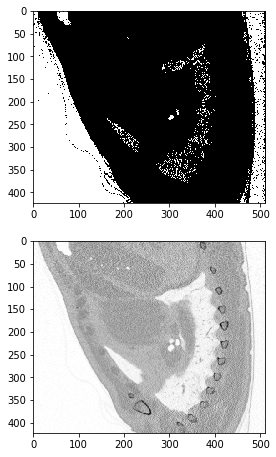

In [18]:
# volument

tra_img_list = get_file_list(tra_img_dir, 'dcm')[0]
img_np = load_itk_file(tra_img_list[5])[1]

ann_img_list = get_file_list(tra_ann_dir, 'mhd')[0]
ann_np = load_itk_file(ann_img_list[5])[1]

print(img_np.shape)
threshold = -850
img_binary = img_np.copy()
img_binary[img_binary >= threshold] = 1
img_binary[img_binary < threshold] = 0

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.imshow(img_binary[:, :, 314], cmap='Greys')
plt.subplot(3, 1, 2)
plt.imshow(img_np[:, :, 314], cmap='Greys')
# plt.subplot(3, 1, 3)
# plt.imshow(ann_np[:, :, 314])

# plt.hist(img_np[:, :, 314].flatten(), bins=100)

In [19]:
# conn_comp = connected_comp(img_binary[:, :, 148:152])
# print(np.unique(conn_comp))
get_file_list(tra_img_dir, 'dcm')

(['./assignment_3/training/images/scan17.dcm',
  './assignment_3/training/images/scan07.dcm',
  './assignment_3/training/images/scan01.dcm',
  './assignment_3/training/images/scan05.dcm',
  './assignment_3/training/images/scan12.dcm',
  './assignment_3/training/images/scan18.dcm',
  './assignment_3/training/images/scan04.dcm',
  './assignment_3/training/images/scan10.dcm',
  './assignment_3/training/images/scan08.dcm',
  './assignment_3/training/images/scan15.dcm'],
 ['scan17.dcm',
  'scan07.dcm',
  'scan01.dcm',
  'scan05.dcm',
  'scan12.dcm',
  'scan18.dcm',
  'scan04.dcm',
  'scan10.dcm',
  'scan08.dcm',
  'scan15.dcm'])

In [20]:
from functools import reduce
from tqdm import tqdm_notebook


def neighbor_labels(conn_comps, point):
    """
    Returns a set of all neighbouring labels for the given point.
    """
    labels = np.zeros((3, 3, 3), dtype=int)
    for dx in range(3):
        for dy in range(3):
            for dz in range(3):
                # Substracting 1 from indices because we are using range(3)
                labels[dx, dy, dz] = conn_comps[point[0] + dx - 1, point[1] + dy - 1, point[2] + dz - 1]

    try:
        return_value = set(labels[labels != 0])
    except:
        return_value = None
    return return_value
        
                    
@jit
def connected_airway_comp(conn_comps):
    """
    Creates a lookup dict for connected labels from connected components array.
    """
    lookup_dict = {i: set() for i in range(1, np.max(conn_comps)+1)}
    
    n_rows, n_cols, n_slice = conn_comps.shape
    for row in tqdm_notebook(range(1, n_rows-1)):
        for col in range(1, n_cols-1):
            for sl in range(1, n_slice-1):
                # If the current point is 1, then check for neighbor and if there is a neighbour
                # assign it's label to current point.
                current_label = conn_comps[row, col, sl]
                if current_label > 0:
                    labels = neighbor_labels(conn_comps, (row, col, sl))
                    if labels is not None:
                        lookup_dict[current_label] = lookup_dict[current_label].union(labels)
    return lookup_dict


def connected_comp_lookup(lookup_dict):
    """
    Creates the groups of connected labels from lookup dict. 
    """
    for k, v in lookup_dict.items():
        temp = reduce(lambda x, y: x.union(y), [lookup_dict[i] for i in lookup_dict[k]])
        lookup_dict[k] = lookup_dict[k].union(temp)
    return lookup_dict

In [124]:
lookup_dict = {1: {2}, 2: {1}, 3: {4, 5, 7}, 4:{3, 6}, 5:{3,6}, 6:{4, 5}, 7:{3}}

# connected_comps = connected_comps(dummy_array)
# lookup_dict = connected_airway_comp(connected_comps)
print(connected_comp_lookup(lookup_dict))


# a = np.array([1, 2, 3, 4])
# a[np.isin(a, [3, 4])] = 1
# print(a)

{1: {1, 2}, 2: {1, 2}, 3: {3, 4, 5, 6, 7}, 4: {3, 4, 5, 6, 7}, 5: {3, 4, 5, 6, 7}, 6: {3, 4, 5, 6, 7}, 7: {3, 4, 5, 6, 7}}


In [125]:
def get_airway_segmentation(img_np, seed_point, thresholds, voxel_volume):
    ''' Airway segmentation in CT scan based on connected components and explosion control.'''
    
    # initialize list of volumes
    volumes = []
    
    # try all thresholds and compute airway volume for each of them
    for threshold in thresholds:
        print('-----------------------------------------')
        print('processing threshold {}'.format(threshold))

        # extract a binarized version of the image by applying the threshold(s)
        img_binary = img_np.copy()
        img_binary[img_binary > threshold] = 1
        img_binary[img_binary < threshold] = 0

        # run connected-components algorithm on the binary image and label each region,
        # you can use one of the functions that we have seen in the last lecture
        # or that we used in the first assignment
        conn_comps = connected_comps_new(img_binary)
     
        print('-> found {} connected components'.format(np.max(conn_comps)))

        # get the label of the seed point 
        seed_point_label = get_seed_point_label(conn_comps, seed_point)
        import pdb; pdb.set_trace()
        print('-> seed point label = {}'.format(seed_point_label))

        if seed_point_label != 0:
            
            # extract airways as the connected component that has the label of the seed point
            lookup_dict = connected_airway_comp(conn_comps)
            print(lookup_dict)
            airways = np.zeros(img_binary.shape, dtype=int)
            airways[np.isin(conn_comps, (connected_comp_lookup(lookup_dict)[seed_point_label]))] = 1
            print(airways)

            # remove voxels in the upper part of the trachea, to make the volume
            # compatible with what measured in the training set
            airways[seed_point[0]:] = 0 # CT scans are acquired from bottom to top

            # compute the airway volume in mm^3
            airway_volume_mm3 = voxel_volume * np.sum(airways)

            # add the computed volume to the list
            volumes.append(airway_volume_mm3)
            print('--> airway volume = {} mm^3'.format(airway_volume_mm3))
        else:
            volumes.append(np.inf)
            print('--> airway volume = 0 mm^3')

    # visualize volume trend
    plt.plot(thresholds, volumes)
    plt.xlabel('HU')
    plt.ylabel('mm^3')
    plt.plot(thresholds, mean_volume_mm3*np.ones((len(thresholds, ))), '--r')
    plt.show()

    # find optimal threshold, which minimizes the "explosion" of segmentation in the parenchyma
    optimal_threshold = -800

    print('optimal threshold {} found'.format(optimal_threshold))

    # Apply the optimal threshold to the scan to get airway segmentation.
    # Basically, you have to repeat steps that you have implemented in 
    # the previous 'for loop' already, but this time you don't need to remove voxels 
    # in the upper part of the trachea, the evaluation algorithm will handle this
    print('extracting airways...')
    img_binary = img_np.copy()
    img_binary[img_binary > optimal_threshold] = 1
    img_binary[img_binary < optimal_threshold] = 0
    
    conn_comps = conn_comps = connected_comps_new(img_binary)
    seed_point_label = get_seed_point_label(conn_comps, seed_point)
    lookup_dict = connected_airway_comp(conn_comps)
    print(lookup_dict)
    
    airways = np.zeros(img_binary.shape, dtype=int)
    airways[np.isin(conn_comps, (connected_comp_lookup(lookup_dict)[seed_point_label]))] = 1
    airways_segmentation = airways
    
    return airways_segmentation

#### Question
What kind of connectivity did you choose for the connected component algorithm and why?

*Your answer here.* We have used 8-connectivity. <b> Finish this when have tried other connectivity </b>

????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????

### Main script to run airway segmentation on the test set
Now that you have implemented all the functions necessary to extract airways from a given CT scan, you can run your algorithm on the entire test set and submit the results.
But first you have to define the threshold (or the thresholds) you want to use in the connected component algorithm. Since the test script expects a list of values, even if you want to use only one value, put it in a list. 

In [126]:
# threshold(s) to consider
thresholds = [-800, -850]

#### Question
What is the theoretically expected intensity value (in Hounsfield unit) for voxel in the airway lumen? What is a plausible range of values that you can test for airway segmentation?

*Your answer here.* Based on 'Extraction  of  Samples  From  Airway  and  Vessel  Trees  In  3D  Lung  CT Based  On  A  Multi-Scale  Principal  Curve  Tracing  Algorithm' article by S. You et al. The voxels with intensities below -800HU are loosely segmented as air filled regions. As both the airway lumen and lungs are filled with air, background noise inside the lung is often misclassified. The blood and soft tissue have intensities around 50-200HU.  The  voxels  with  intensities  above  -500  HU  are classified as the foreground.

processing scan id 1.0.000.000000.0.00.0.0000000000.0000.0000000000.000
scan loaded with size (476, 512, 512)


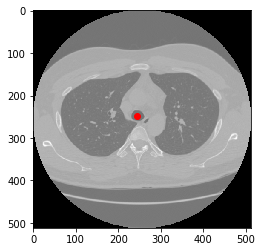

-----------------------------------------
processing threshold -800
-> found 32966 connected components
> <ipython-input-125-d14220c4a06f>(27)get_airway_segmentation()
-> print('-> seed point label = {}'.format(seed_point_label))


In [ ]:
# extract and save airway segmentation from test cases
for test_img_filename in tes_img_fls:

    # extract scan id from filename, will be used to save the result image
    scan_id = os.path.splitext(ntpath.basename(test_img_filename))[0]
    print('processing scan id {}'.format(scan_id))

    # load ITK image in ITK and numpy format
    img_itk, img_itk_np = load_itk_file(test_img_filename) 
    print('scan loaded with size {}'.format(img_itk_np.shape))                     

    # extract scan parameters
    img_params = get_scan_params(img_itk)

    # get voxel volume
    voxel_volume_mm3 = get_voxel_volume_mm3(img_params['spacing'])   

    # get seed point coordinates from the defined dictionary
    seed_point = seed_points[scan_id]

    # visualize slice with seed point
    plt.imshow(img_itk_np[seed_point[0]].squeeze(), cmap='gray')
    plt.scatter(seed_point[2], seed_point[1], c='r')
    plt.show()

    # airway segmentation using the function that you have implemented
    airways = get_airway_segmentation(img_itk_np, seed_point, thresholds, voxel_volume_mm3)

    # save to disk
    print('saving segmentation result to disk')
    outputfile = os.path.join(result_output_folder, scan_id+'.mhd')
    save_itk_file(airways, outputfile, img_params)
    print('done!')


One of the output produced by the functions that we have prepared is a plot of the trend of airway volume as a function of the threshold(s) that you have picked. Based on this plot, you may think of narrowing the search interval for your thresholds, and try to further fine-tune the threshold (and other parameters, like the connectivity, etc.) and try to improve the results based on plain connected components segmentation.

### Submit your results
The airway segmentation results for the test set have been stored in the result folder that you defined at the beginning of the notebook (```result_output_folder```).

Before submitting the results, you may want to have a look at your results by using the MeVisLab network provided. You can use the network to load the test scan and to show the segmentation results in overlay. This can give you a feeling what to expect from the evaluation, and can also give some feedback how to improve your method, apart from the numerical results that you will get.

Executing the cell below will create a zip-file of the images with the segmentation results.

In [ ]:
shutil.make_archive('results', 'zip', result_output_folder)

You can now download this zipfile with this link: [results.zip](results.zip).

Check that the content of ```results.zip``` looks like this:

```
results
|- 1.0.000.000000.0.00.0.0000000000.0000.0000000000.000.mhd
|- 1.0.000.000000.0.00.0.0000000000.0000.0000000000.000.zraw
|- 1.2.276.0.28.3.0.14.4.0.20090213134050413.mhd
|- 1.2.276.0.28.3.0.14.4.0.20090213134050413.zraw
|- 1.2.276.0.28.3.0.14.4.0.20090213134114792.mhd
|- 1.2.276.0.28.3.0.14.4.0.20090213134114792.zraw
|- 1.2.392.200036.9116.2.2.2.1762676169.1080882991.2256.mhd
|- 1.2.392.200036.9116.2.2.2.1762676169.1080882991.2256.zraw
|- 1.2.840.113704.1.111.2004.1131987870.11.mhd
|- 1.2.840.113704.1.111.2004.1131987870.11.zraw
|- 1.2.840.113704.1.111.2296.1199810886.7.mhd
|- 1.2.840.113704.1.111.2296.1199810886.7.zraw
|- 1.2.840.113704.1.111.2296.1199810941.11.mhd
|- 1.2.840.113704.1.111.2296.1199810941.11.zraw
|- 1.2.840.113704.1.111.4400.1131982359.11.mhd
|- 1.2.840.113704.1.111.4400.1131982359.11.zraw
|- 1.3.12.2.1107.5.1.4.50585.4.0.7023259421321855.mhd
|- 1.3.12.2.1107.5.1.4.50585.4.0.7023259421321855.zraw
|- 2.16.840.1.113669.632.21.3825556854.538251028.390606191418956020.mhd
\- 2.16.840.1.113669.632.21.3825556854.538251028.390606191418956020.zraw
```

Next, upload your result to the challenge website (https://exact09.grand-challenge.org/) at the *Submit* section and see how well you performed compared to your fellow students! You can submit as often as you want, only the best result counts.

Note that the evaluation may take several minutes, because the platform has to process 3D data, and there may be several submissions to be evaluated at the same time. You can check the status of the evaluation of your submission at any time on grand-challenge.org.

## Task 2. Improving airway segmentation

Now that you have segmented airways using the connected component algorithm, you can improve the airway segmentation by using other (additional) techniques. For this task, you can use all the knowledge that you have on *filtering*, *texture analysis*, *classification* and *morphology*.
There is no specific limitation to what you can do here, pick the technique (or the techniques) that you think is the most appropriate, and try to improve your results. **Be creative!**

## DO NOT MODIFY THE CELLS ABOVE! INSTEAD, MAKE NEW CELLS BELOW AND REUSE CODE FROM PREVIOUS CELLS!


In [ ]:
# You can add your new code here.
# Add more cells using the "+" button in the toolbar of this notebook.
# If you want to add "code" cells, select the "Code" type (default).
# If you want to add "text" cells, select the "Markdown" type.